## Ivan Barros, Grasielly Lima

# Introdução

Este projeto tem como objetivo fornecer uma análise detalhada e abrangente dos dados de partidas de futebol da temporada atual da Premier League, com foco específico no número de escanteios. Utilizando técnicas de automação para coleta de dados e processamento inteligente (utilizando playwright e pandas para coletar e organizar dados de estatísticas de jogadores de futebol), buscamos extrair insights valiosos tanto na visão agrupada por clubes quanto na visão agrupada por jogadores. Esta abordagem nos permitirá entender melhor os padrões e as tendências associadas aos escanteios, bem como suas interações e correlações com outras variáveis relevantes no contexto do futebol.

# Problema

A análise do número de escanteios em partidas de futebol é uma área de interesse tanto para analistas esportivos quanto para treinadores e jogadores. No entanto, a obtenção e processamento desses dados de forma eficiente pode ser desafiador devido ao volume e complexidade das informações disponíveis. 

Nosso objetivo é resolver este problema coletando dados estatísticos detalhados de jogadores e equipes a partir de fontes confiáveis, organizando e analisando essas informações para identificar padrões significativos. Especificamente, queremos:

1. **Agrupamento por Clubes**: Examinar como os diferentes clubes se comportam em termos de número de escanteios, identificando quais clubes têm maior ou menor propensão a ganhar escanteios e quais variáveis podem estar correlacionadas a isso.
   
2. **Agrupamento por Jogadores**: Analisar a contribuição individual dos jogadores para o número de escanteios, permitindo identificar quais jogadores são mais eficientes em ganhar escanteios e entender as interações entre suas estatísticas individuais e o número de escanteios.

Além disso, serão exploradas interações e correlações com outras variáveis, como gols, assistências, cartões, entre outros. Esta análise multifacetada permitirá uma compreensão mais completa dos fatores que influenciam o número de escanteios e como eles se relacionam com o desempenho geral da equipe e dos jogadores.

# Extração de dados

O script navega até páginas web, extrai informações relevantes e organiza esses dados em um formato estruturado para posterior análise. Foram utilizadas as bibliotecas `playwright` para navegação web automatizada e `pandas` para manipulação de dados. O objetivo do projeto é extrair dados de desempenho de jogadores do site [Opta](https://optaplayerstats.statsperform.com/) (utilizado como fonte de informação para diversas casas de apostas conhecidas no mercado nacional) e organizar esses dados em um formato estruturado para análise.

### Dependências

O projeto utiliza as seguintes bibliotecas Python:
- `pandas` para manipulação de dados
- `playwright` para navegação web automatizada
- `time` para pausas controladas durante a execução do script

```python
import pandas as pd
from playwright.sync_api import sync_playwright
import time
import os
```

# Extração de dados

### Funções Principais
1. get_match_page_hrefs

Essa função navega até uma página de resultados de jogos e coleta os links para as páginas individuais de cada partida.

```python
def get_match_page_hrefs(page_url):
    with sync_playwright() as p:
        browser = p.chromium.launch(executable_path="/usr/bin/google-chrome", headless=False)
        page = browser.new_page()

        try:
            page.goto(page_url)
            page.wait_for_load_state("networkidle")

            match_page_hrefs = page.query_selector_all("a.Opta-MatchLink")
            hrefs = []
            if match_page_hrefs:
                for match_page_href in match_page_hrefs:
                    hrefs.append(match_page_href.get_attribute("href"))
            else:
                print("No Match Page hrefs found.")
            return hrefs

        except Exception as e:
            print("Error:", e)

        finally:
            browser.close()
```

2. scrape_stats

Essa função extrai as estatísticas dos jogadores de uma página específica de partida. Ela coleta os nomes dos jogadores e suas respectivas estatísticas, bem como os nomes dos clubes envolvidos na partida.

```python
def scrape_stats(page):
    headers = page.query_selector_all('.Opta-Player-Stats th.Opta-Stat abbr')
    header_names = [header.inner_text() for header in headers]

    rows = page.query_selector_all('tbody tr')
    data_dict = {header_name: [] for header_name in header_names}
    data_dict['Player'] = []
    for row in rows:
        player_name_element = row.query_selector('th.Opta-Player')
        if player_name_element:
            player_name = player_name_element.inner_text()
            if player_name != 'Total':
                stats = [cell.inner_text() for cell in row.query_selector_all('.Opta-Stat')]
                data_dict['Player'].append(player_name)
                for header_name, stat in zip(header_names, stats):
                    data_dict[header_name].append(stat)

    team_elements = page.query_selector_all('ul.Opta-Cf')

    clubs = []

    for team_element in team_elements:
        club_list_items = team_element.query_selector_all('li:not(.Opta-On) a')
        for item in club_list_items:
            club = item.inner_text()
            clubs.append(club)

    game_dict = {'Team': [1, 0], 'Club': clubs[0:2]}

    return data_dict, game_dict
```

3. load_players_clubs

Carrega um arquivo Excel contendo a relação entre jogadores e seus respectivos clubes. Retorna um dicionário onde a chave é o nome do jogador e o valor é o nome do clube.

```python
def load_players_clubs(file_path):
    players_df = pd.read_excel(file_path)
    players_clubs = dict(zip(players_df['Player'], players_df['Club']))
    return players_clubs
```

4. process_page

Essa função processa uma página de partida específica, extrai as estatísticas dos jogadores, associa cada jogador ao seu clube e time (casa ou visitante) e retorna um DataFrame organizado.

```python
def process_page(page_url, players_clubs):
    with sync_playwright() as p:
        browser = p.chromium.launch(executable_path="/usr/bin/google-chrome", headless=False)
        page = browser.new_page()
        page.goto(page_url)
        time.sleep(5)
        data_dict, game_dict = scrape_stats(page)
        browser.close()

    df = pd.DataFrame(data_dict)
    player_col = df.pop('Player')
    df.insert(0, 'Player', player_col)

    df = df.head(len(df) // 2)

    length_df = len(df)

    df_team_club = pd.DataFrame({'Team': [None] * length_df, 'Club': [None] * length_df})

    for idx, player in enumerate(df['Player']):
        if player in players_clubs:
            club = players_clubs[player]
            try:
                team_index = game_dict['Club'].index(club)
                team = game_dict['Team'][team_index]
            except ValueError:
                # Se o clube não estiver presente no game_dict, deixe em branco
                team = ''
            df_team_club.loc[idx, 'Club'] = club
            df_team_club.loc[idx, 'Team'] = team


    # Drop rows with missing club information
    df_team_club = df_team_club.dropna()

    # Merge the data frames
    df = pd.concat([df, df_team_club], axis=1)

    return df

Função Principal main

Essa função principal orquestra o fluxo do script, carregando a lista de jogadores e clubes, obtendo os links das páginas de partidas, processando cada página de partida e salvando os dados coletados em arquivos CSV.

```python
def main():
    players_clubs = load_players_clubs("players_list.xlsx")

    page_url_1 = "https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/results"
    hrefs = get_match_page_hrefs(page_url_1)

    for idx, href in enumerate(hrefs, start=1):
        print(f"Processing {href}...")
        df = process_page(href, players_clubs)
        if len(df) > 21:
            csv_filename = f"csvs/match_{idx}_stats.csv"
            df.to_csv(csv_filename)
            print(df)
            print("Ok")
        else:
            print("Skipped - Number of rows in DataFrame is not the minimum.")

if __name__ == "__main__":
    main()

## Execução do Código explicado acima

In [28]:
# Código para instalar as dependências listadas em requirements.txt
!pip install -r requirements.txt

In [48]:
# Código para executar o arquivo extrac_data.py
!python extrac_data.py

Processing https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/match/view/er8a46kqojgwtslqc8k3827f8...
Ok
Processing https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/match/view/eqzazn9mgdkxfmz4eq7tdv0no...
Ok
Processing https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/match/view/eqq8pegthopaveogu29pau2hg...
Ok
Processing https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/match/view/eqh6e68x3fq0f8pacriyur1g4...
Ok
Processing https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/match/view/eq8a81rt8ki4aep2jcqng7ims...
Ok
Processing https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/match/view/epzc6diykymufph7euswxsh04...
Ok
Processing https://optaplayerstats.statsperfor

# Análise

## Abordagem Clubes

In [49]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [50]:
arquivos_csv = [arquivo for arquivo in os.listdir('csvs') if arquivo.endswith('.csv')]

dados_clubes = pd.DataFrame()

for arquivo in arquivos_csv:
    caminho_completo = os.path.join('csvs', arquivo)  # Gera o caminho completo do arquivo
    dados = pd.read_csv(caminho_completo)  # Usa o caminho completo para ler o arquivo
    dados = dados.dropna()

    df_grouped = dados.drop(columns=["Player"]).groupby(["Club", "Team"]).sum().reset_index()

    df_grouped.rename(columns={col: col + "_Pro" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]}, inplace=True)

    df_grouped_against = df_grouped.copy()

    for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]:
        df_grouped_against[col + "_Against"] = df_grouped[col + "_Pro"].sum() - df_grouped[col + "_Pro"]

    columns_order = ["Club", "Team"] + [col + "_Pro" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]] + [col + "_Against" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]]
    df_grouped_against = df_grouped_against[columns_order]

    dados_clubes = pd.concat([dados_clubes, df_grouped_against], ignore_index=True)

dados_clubes.reset_index(drop=True, inplace=True)

dados_clubes.head(6)

,Club,Team,G_Pro,A_Pro,RC_Pro,YC_Pro,Crn_Pro,S_Pro,SOnT_Pro,BS_Pro,...,Crn_Against,S_Against,SOnT_Against,BS_Against,P_Against,C_Against,Tk_Against,O_Against,FC_Against,FW_Against
0,Brighton & Hove Albion FC,1.0,0,0,0,0,6,14,3,8,...,5,11,4,5,454,6,21,1,9,10
1,Manchester United FC,0.0,2,0,0,3,5,11,4,5,...,6,14,3,8,424,20,22,0,9,8
2,Liverpool FC,1.0,2,1,0,1,10,36,14,10,...,2,3,2,1,284,4,21,2,9,10
3,Wolverhampton Wanderers FC,0.0,0,0,1,1,2,3,2,1,...,10,36,14,10,621,25,22,3,14,10
4,Arsenal FC,1.0,2,2,0,3,7,26,5,10,...,1,5,2,1,267,3,13,4,11,7
5,Everton FC,0.0,1,0,0,3,1,5,2,1,...,7,26,5,10,631,27,6,1,7,10


In [51]:
dados_clubes_pro = dados_clubes.iloc[:, :16]
dados_clubes_against = pd.concat([dados_clubes.iloc[:, :2], dados_clubes.iloc[:, -14:]], axis=1)

# Renomeando as colunas do dataframe dados_clubes_pro
dados_clubes_pro.columns = [col.replace('_Pro', '') for col in dados_clubes_pro.columns]

# Renomeando as colunas do dataframe dados_clubes_against
dados_clubes_against.columns = [col.replace('_Against', '') for col in dados_clubes_against.columns]


In [52]:
dados_clubes_pro

,Club,Team,G,A,RC,YC,Crn,S,SOnT,BS,P,C,Tk,O,FC,FW
0,Brighton & Hove Albion FC,1.0,0,0,0,0,6,14,3,8,424,20,22,0,9,8
1,Manchester United FC,0.0,2,0,0,3,5,11,4,5,454,6,21,1,9,10
2,Liverpool FC,1.0,2,1,0,1,10,36,14,10,621,25,22,3,14,10
3,Wolverhampton Wanderers FC,0.0,0,0,1,1,2,3,2,1,284,4,21,2,9,10
4,Arsenal FC,1.0,2,2,0,3,7,26,5,10,631,27,6,1,7,10
5,Everton FC,0.0,1,0,0,3,1,5,2,1,267,3,13,4,11,7
6,AFC Bournemouth,0.0,0,0,0,3,5,22,5,4,320,20,22,1,9,5
7,Chelsea FC,1.0,3,1,0,2,6,14,5,6,498,15,23,0,5,8
8,Manchester City FC,1.0,3,3,0,0,11,28,12,7,671,14,17,3,3,10
9,West Ham United FC,0.0,1,0,0,1,2,3,2,0,278,6,14,0,12,3


In [53]:
def plot_media_por_clube(df, variable):
    # Calculando a média de cada indicador para cada clube, separando por Team = 0 e Team = 1
    media_por_clube = df.groupby(['Club', 'Team']).mean().unstack()

    # Plotando o gráfico de barras
    fig, ax = plt.subplots(figsize=(15, 8))

    # Definindo a largura das barras
    bar_width = 0.35

    # Definindo as posições das barras
    posicoes = range(len(media_por_clube))

    # Selecionando os dados para Team = 0
    media_team_0 = media_por_clube.loc[:, (variable, 0)].values

    # Selecionando os dados para Team = 1
    media_team_1 = media_por_clube.loc[:, (variable, 1)].values

    # Plotando as barras para Team = 0
    bars_team_0 = ax.bar(posicoes, media_team_0, bar_width, label=f'{variable} Team 0')

    # Plotando as barras para Team = 1
    bars_team_1 = ax.bar([p + bar_width for p in posicoes], media_team_1, bar_width, label=f'{variable} Team 1')

    # Adicionando rótulos de valor nas barras para Team = 0
    for bar in bars_team_0:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize = 8)

    # Adicionando rótulos de valor nas barras para Team = 1
    for bar in bars_team_1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize = 8)

    # Definindo os rótulos do eixo x como os clubes
    ax.set_xticks([p + bar_width / 2 for p in posicoes])
    ax.set_xticklabels(media_por_clube.index)

    # Adicionando legendas, título e rótulos dos eixos
    ax.legend()
    ax.set_xlabel('Clube')
    ax.set_ylabel('Média')
    ax.set_title(f'Média de {variable} para cada clube, separado por Team')

    # Exibindo o gráfico
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


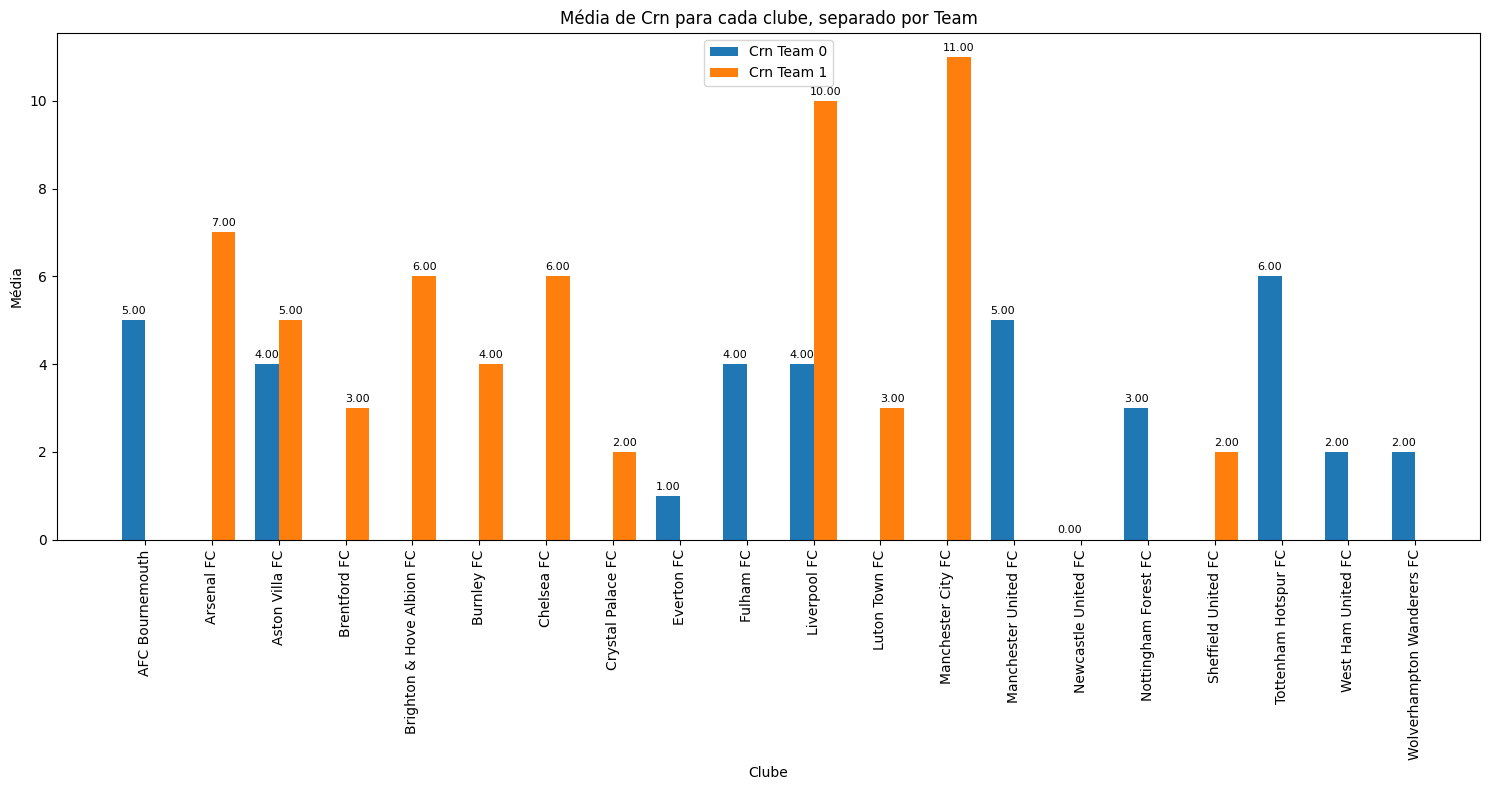

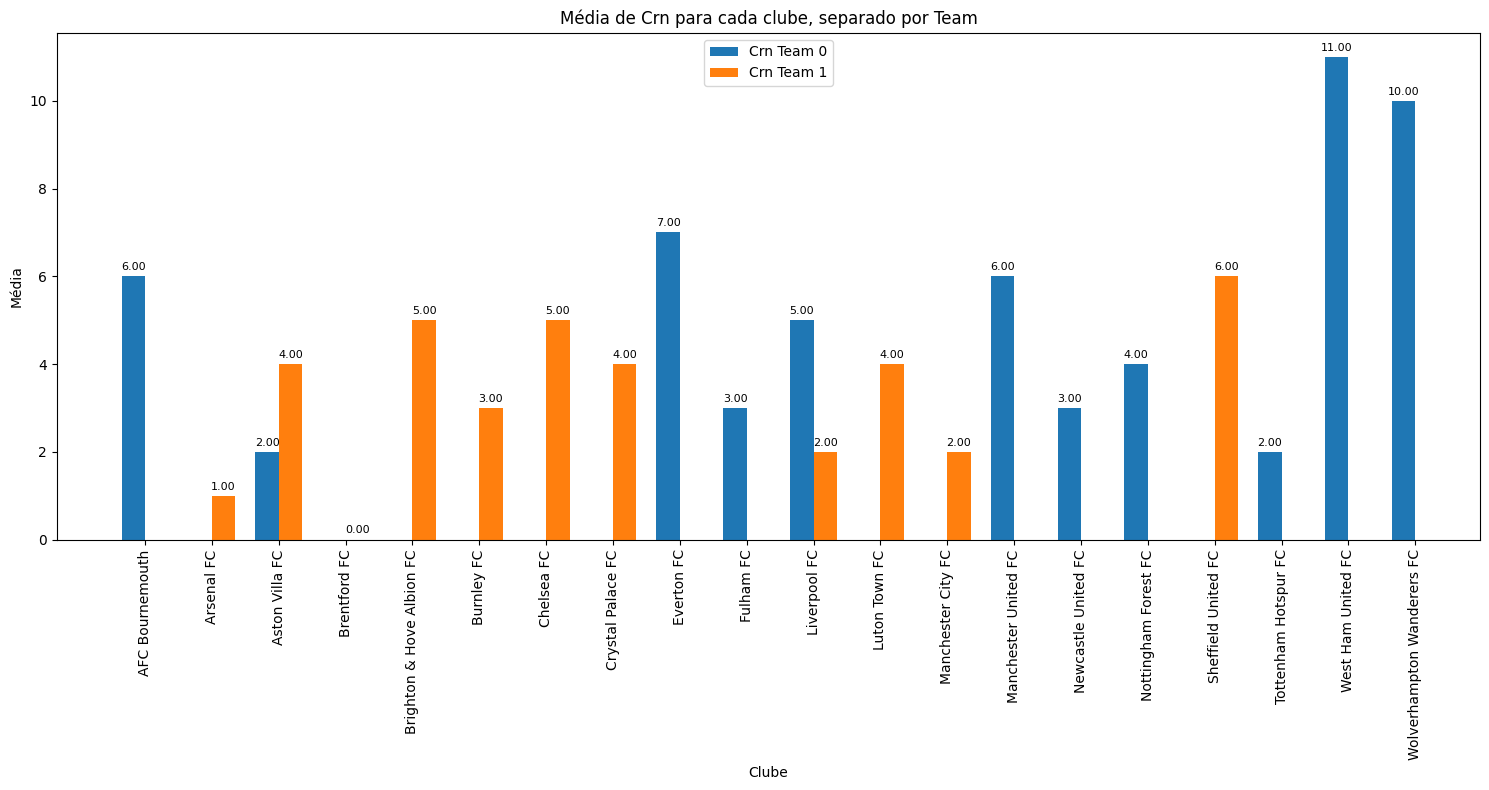

In [54]:
plot_media_por_clube(dados_clubes_pro, 'Crn')
plot_media_por_clube(dados_clubes_against, 'Crn')

In [55]:
def print_media_por_clubes(club1, club2):
    # Filtrando os dados para o primeiro clube e Team = 1
    media_club1_team1_pro = dados_clubes_pro.loc[(dados_clubes_pro['Club'] == club1) & (dados_clubes_pro['Team'] == 1), 'Crn'].mean()
    media_club1_team1_against = dados_clubes_against.loc[(dados_clubes_against['Club'] == club1) & (dados_clubes_against['Team'] == 1), 'Crn'].mean()
    
    # Filtrando os dados para o segundo clube e Team = 0
    media_club2_team0_pro = dados_clubes_pro.loc[(dados_clubes_pro['Club'] == club2) & (dados_clubes_pro['Team'] == 0), 'Crn'].mean()
    media_club2_team0_against = dados_clubes_against.loc[(dados_clubes_against['Club'] == club2) & (dados_clubes_against['Team'] == 0), 'Crn'].mean()
    
    # Imprimindo os valores de média
    print(f'{club1} costuma fazer em casa: {media_club1_team1_pro:.2f} e {club2} costuma ceder fora de casa {media_club2_team0_against:.2f}:')
    print(f'{club2} costuma fazer fora de casa: {media_club2_team0_pro:.2f} e {club1} costuma ceder em casa {media_club1_team1_against:.2f}:\n')

    media_home = (media_club1_team1_pro + media_club2_team0_against)/2
    media_out = (media_club2_team0_pro + media_club1_team1_against)/2

    print(f'se a gente for fazer uma média muito louca, {club1} vai fazer: {media_home:.2f} e {club2} vai fazer: {media_out:.2f}:')


In [56]:
print_media_por_clubes('Manchester United FC', 'Sheffield United FC')

Manchester United FC costuma fazer em casa: nan e Sheffield United FC costuma ceder fora de casa nan:
Sheffield United FC costuma fazer fora de casa: nan e Manchester United FC costuma ceder em casa nan:

se a gente for fazer uma média muito louca, Manchester United FC vai fazer: nan e Sheffield United FC vai fazer: nan:


## Abordagem jogadores

In [57]:
arquivos_csv = [arquivo for arquivo in os.listdir('csvs') if arquivo.endswith('.csv')]

dados_players = pd.DataFrame()

for arquivo in arquivos_csv:
    caminho_completo = os.path.join('csvs', arquivo)  # Gera o caminho completo do arquivo
    dados = pd.read_csv(caminho_completo)  # Usa o caminho completo para ler o arquivo
    dados = dados.dropna()

    dados_players = pd.concat([dados_players, dados], ignore_index=True)

dados_players.reset_index(drop=True, inplace=True)

df_grouped = dados_players.groupby(["Player", "Team", "Club"]).sum().reset_index()

columns_order = ["Player", "Club", "Team"] + [col for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]]
df_grouped = df_grouped[columns_order]

df_grouped


,Player,Club,Team,G,A,RC,YC,Crn,S,SOnT,BS,P,C,Tk,O,FC,FW
0,A. Ahmedhodžić,Sheffield United FC,1.0,0,0,0,0,0,0,0,0,20,1,3,0,0,1
1,A. Brooks,Sheffield United FC,1.0,0,0,0,0,0,0,0,0,6,0,0,0,1,0
2,A. Cresswell,West Ham United FC,0.0,0,0,0,0,0,0,0,0,39,1,0,0,0,0
3,A. Diallo,Manchester United FC,0.0,0,0,0,0,0,1,0,0,31,0,2,0,0,0
4,A. Doucouré,Everton FC,0.0,0,0,0,1,0,0,0,0,28,0,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Y. Wissa,Brentford FC,1.0,1,1,0,1,0,4,1,1,19,0,0,0,2,3
298,Y. Yarmoliuk,Brentford FC,1.0,0,0,0,0,0,1,1,0,6,0,0,0,0,0
299,Youssef Chermiti,Everton FC,0.0,0,0,0,0,0,0,0,0,5,0,0,1,0,0
300,Z. Amdouni,Burnley FC,1.0,0,0,0,0,0,4,0,1,24,0,0,0,1,2


In [58]:
def filter_and_sort_df(df, club, team):
    filtered_df = df.loc[(df["Club"] == club) & (df["Team"] == team)].sort_values(by='Crn', ascending=False)
    
    # Plotando o gráfico de barras
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(filtered_df['Player'], filtered_df['Crn'])
    
    # Adicionando rótulos de valor nas barras
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    
    # Definindo os rótulos e título
    ax.set_xlabel('Jogador')
    ax.set_ylabel('Crn')
    ax.set_title(f'Resultados de Crn por jogador - {club} (Team {team})')
    
    # Rotacionando os rótulos do eixo x para facilitar a leitura
    plt.xticks(rotation=90)
    
    # Exibindo o gráfico
    plt.tight_layout()
    plt.show()


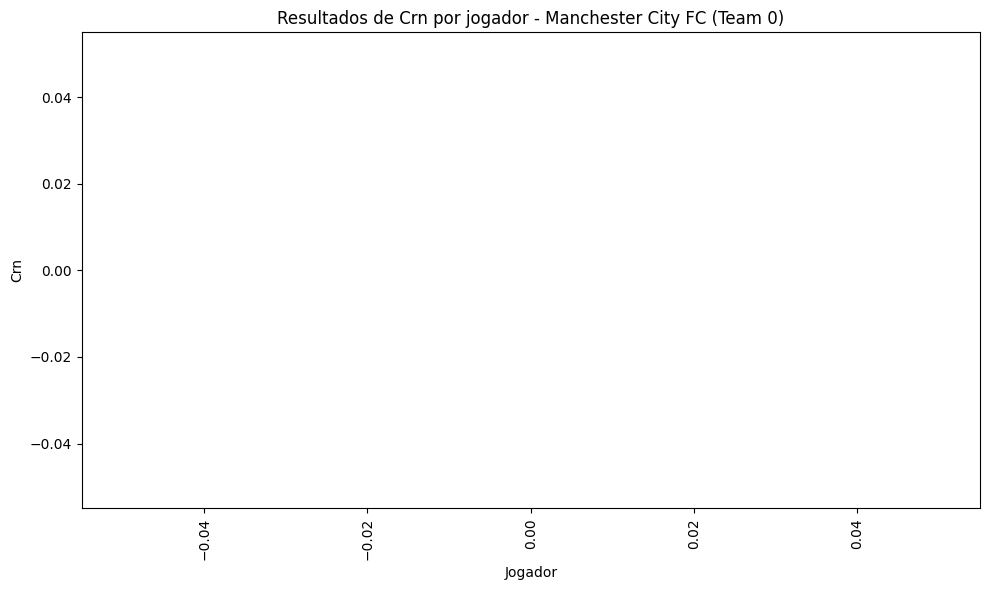

In [59]:
filter_and_sort_df(df_grouped, "Manchester City FC", 0)

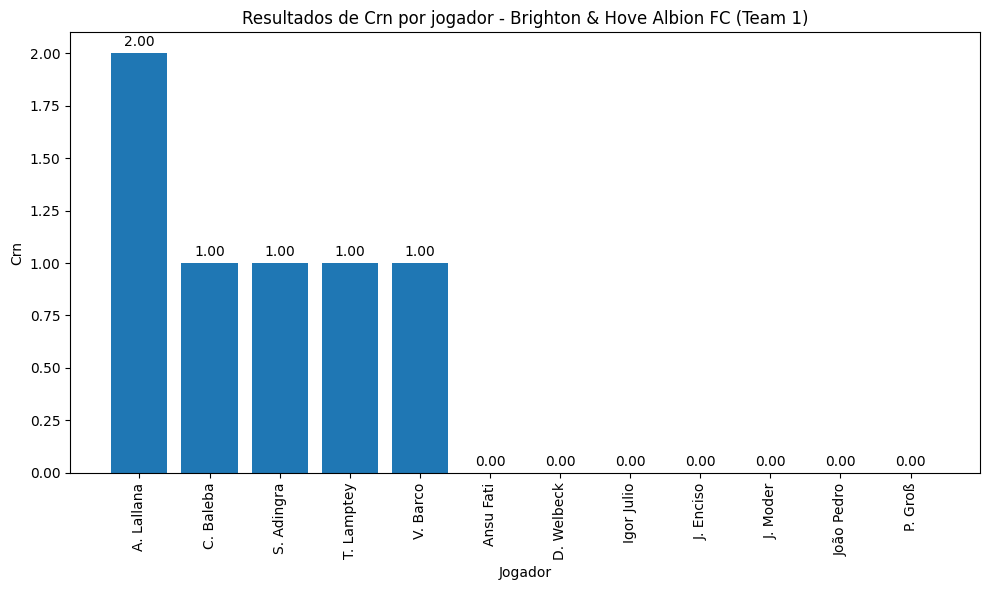

In [60]:
filter_and_sort_df(df_grouped, "Brighton & Hove Albion FC", 1)

In [61]:
df_grouped2 = df_grouped[["Player", "Team", "Crn"]]

mean_corners_per_game = dados_players.groupby(['Player', 'Team'])['Crn'].mean()

df_grouped2['Crn_Score'] = df_grouped2.apply(lambda row: mean_corners_per_game[(row['Player'], row['Team'])], axis=1)


/tmp/ipykernel_30927/3593699371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grouped2['Crn_Score'] = df_grouped2.apply(lambda row: mean_corners_per_game[(row['Player'], row['Team'])], axis=1)


In [62]:
def print_corners_mean(player, team):
    df_play = df_grouped2[(df_grouped2["Player"] == player) & (df_grouped2["Team"] == team)]
    if team == 1:
        print(f'{player} conquistou em média {df_play["Crn_Score"].sum()} escanteios por jogo em casa')
    else:
        print(f'{player} conquistou em média {df_play["Crn_Score"].sum()} escanteios por fora de casa')

In [63]:
print_corners_mean("K. De Bruyne", 0)

K. De Bruyne conquistou em média 0.0 escanteios por fora de casa


In [64]:
print_corners_mean("D. Welbeck", 1)
print_corners_mean("J. van Hecke", 1)
print_corners_mean("P. Groß", 1)
print_corners_mean("A. Lallana", 1)
print_corners_mean("C. Baleba", 1)
print_corners_mean("J. Veltman", 1)
print_corners_mean("L. Dunk", 1)
print_corners_mean("J. Moder", 1)
print_corners_mean("João Pedro", 1)
print_corners_mean("V. Barco", 1)
print_corners_mean("J. Steele", 1)

print("\n")

print_corners_mean("P. Foden", 0)
print_corners_mean("Rodri", 0)
print_corners_mean("M. Akanji", 0)
print_corners_mean("Ederson M. Kovačić", 0)
print_corners_mean("J. Gvardiol", 0)
print_corners_mean("Bernardo Silva", 0)
print_corners_mean("J. Álvarez", 0)
print_corners_mean("N. Aké", 0)
print_corners_mean("K. Walker", 0)
print_corners_mean("K. De Bruyne", 0)
print_corners_mean("Matheus Nunes", 0)


D. Welbeck conquistou em média 0.0 escanteios por jogo em casa
J. van Hecke conquistou em média 0.0 escanteios por jogo em casa
P. Groß conquistou em média 0.0 escanteios por jogo em casa
A. Lallana conquistou em média 2.0 escanteios por jogo em casa
C. Baleba conquistou em média 1.0 escanteios por jogo em casa
J. Veltman conquistou em média 0.0 escanteios por jogo em casa
L. Dunk conquistou em média 0.0 escanteios por jogo em casa
J. Moder conquistou em média 0.0 escanteios por jogo em casa
João Pedro conquistou em média 0.0 escanteios por jogo em casa
V. Barco conquistou em média 1.0 escanteios por jogo em casa
J. Steele conquistou em média 0.0 escanteios por jogo em casa


P. Foden conquistou em média 0.0 escanteios por fora de casa
Rodri conquistou em média 0.0 escanteios por fora de casa
M. Akanji conquistou em média 0.0 escanteios por fora de casa
Ederson M. Kovačić conquistou em média 0.0 escanteios por fora de casa
J. Gvardiol conquistou em média 0.0 escanteios por fora de casa

# Conclusão